In [336]:
import numpy as np
import torch
import cv2
import os
from utils import *
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

已加载: 5.jpg, 尺寸: (3, 250, 286)
已加载: 3.jpg, 尺寸: (3, 204, 275)
已加载: 1.jpg, 尺寸: (3, 241, 321)
已加载: 4.jpg, 尺寸: (3, 305, 305)
已加载: 2.jpg, 尺寸: (3, 223, 296)


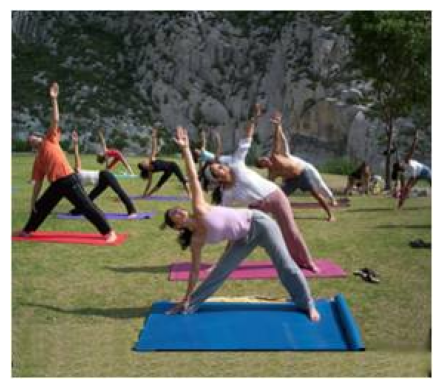

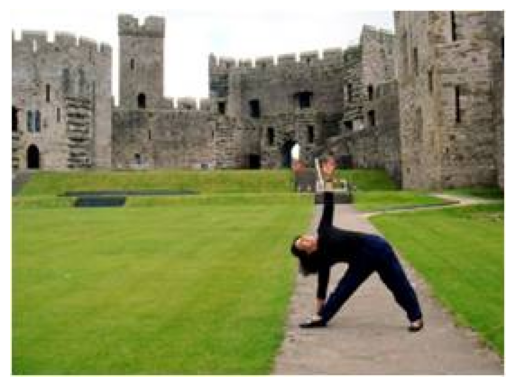

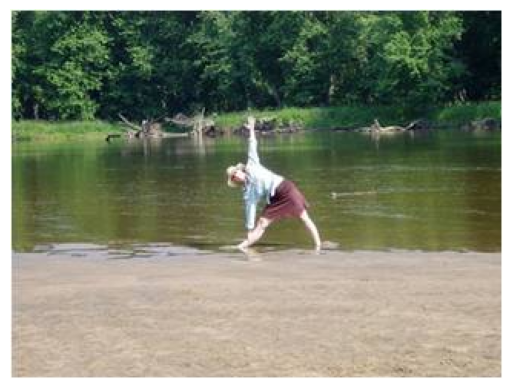

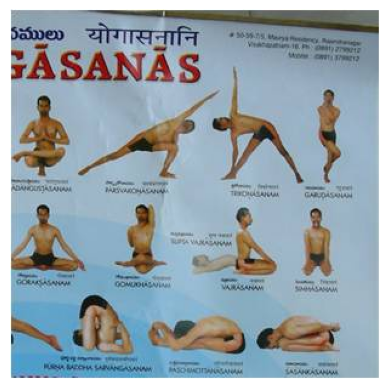

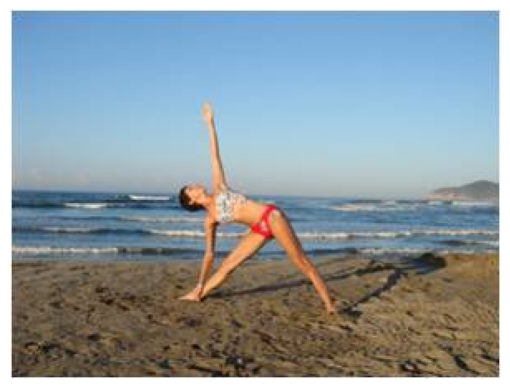

In [346]:
## load the data
path = os.getcwd() + '/../data/'  
images_np = images_np_load(path, plot=False)
images_plot(images_np)

In [338]:
def get_region(c, size, image):
    if len(image.shape) == 3:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2, :]
    else:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2]

def simliarity(image, x1, x2, patchsize, alpha=0.1):
    region1 = get_region(x1, patchsize, image)
    region2 = get_region(x2, patchsize, image)
    #print(x1, x2, region1.shape, region2.shape, image.shape)
    sim = np.exp(-alpha * np.sum((region1 - region2) ** 2))
    return sim

def self_simliarity(image, regionsize=81, patchsize=5):
    H, W = image.shape[0], image.shape[1]
    region_r, patch_r = regionsize // 2, patchsize // 2

    similiarity_map = [[0 for _ in range(W - regionsize + 1)] for _ in range(H - regionsize + 1)]
    for i in range(H - regionsize + 1):
        for j in range(W - regionsize + 1):
            xc = [i + region_r, j + region_r]
            sim = np.zeros((regionsize - patchsize + 1, regionsize - patchsize + 1)).astype(np.float32)
            
            for m in range(regionsize - patchsize + 1):
                for n in range(regionsize - patchsize + 1):
                    y = [i + m + patch_r, j + n + patch_r]
                    sim[m][n] = simliarity(image, xc, y, patchsize)
            similiarity_map[i][j] = sim
    return np.array(similiarity_map)


In [339]:
images_self_sim = [0] * 5

images_self_sim[0] = self_simliarity(np.transpose(images_np[0], [1, 2, 0]))

In [340]:
def log_polar_offsets(regionsize, num_r=4, num_theta=20):
    """生成 log-polar 相对坐标偏移表"""
    r = np.logspace(0, np.log10(regionsize / 2), num_r) - 1
    #r = np.linsapce(0, r_max, num_r)
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)

    rr, tt = np.meshgrid(r, theta, indexing='ij')
    dy = (rr * np.sin(tt)).astype(int)
    dx = (rr * np.cos(tt)).astype(int)
    offsets = np.stack([dy, dx], axis=-1)  # shape (num_r,num_theta,2)

    return offsets

offsets = log_polar_offsets(41)
print(offsets.shape)

(4, 20, 2)


In [341]:
self_sim_polarlog = [0] * 5

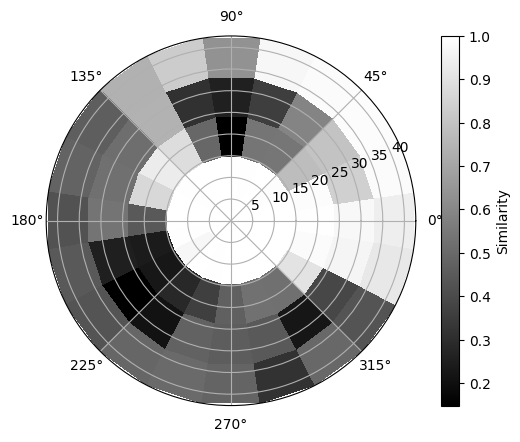

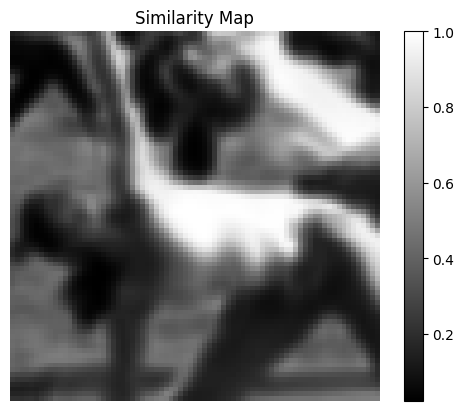

In [ ]:
def visualize_logpolar_feature(sim_feature, r):
    _ , num_theta = sim_feature.shape 
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    Theta, R = np.meshgrid(theta, r, indexing='xy')
    # 创建极坐标图
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    # 绘制扇形图
    c = ax.pcolormesh(Theta, R, sim_feature, shading='auto', cmap='gray')
    ax.set_theta_zero_location("E")  
    ax.set_theta_direction(1)        
    fig.colorbar(c, ax=ax, label='Similarity')
    plt.savefig('../result/sim_logpolar.png')
    plt.show()

def visualize_similarity_map(similarity_map):
    plt.imshow(similarity_map, cmap='gray')  
    plt.colorbar()  
    plt.title("Similarity Map") 
    plt.axis('off')  
    plt.savefig('../result/sim_ori.png')
    plt.show()


def log_polar_conversion(similarity_map, num_r=4, num_theta=20):
    R = similarity_map.shape[0] // 2
    r = np.linspace(1, R, num_r + 1)
    theta = np.linspace(-2*np.pi / (num_theta * 2), 2*np.pi - 2*np.pi / (num_theta * 2), num_theta + 1)
    
    return r[1:], theta[1:]

def update_log_polar_map(similarity_map, r, theta, num_r=4, num_theta=20):
    H, W = similarity_map.shape
    log_polar_map = np.zeros((num_r, num_theta)) 
    center_y, center_x = H // 2, W // 2  
    
    for i in range(H):
        for j in range(W):
            
            dy, dx = center_y - i, j - center_x
            r_val, t_val = np.sqrt(dy**2 + dx**2), (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)
            if t_val > r[-1]:
                t_val = t_val - 2*np.pi
    
            r_idx, t_idx = np.digitize(r_val, r), np.digitize(t_val, theta) % num_theta  
            if r_idx < num_r:
                log_polar_map[r_idx, t_idx] = max(log_polar_map[r_idx, t_idx], similarity_map[i, j])
    
    return log_polar_map


i = images_self_sim[0][100][100]
r, theta = log_polar_conversion(i)
log_polar_map = update_log_polar_map(i, r, theta)

visualize_logpolar_feature(log_polar_map, r)
visualize_similarity_map(i)